# Fine-tuning Embeddings for RAG on Specific Data

As we start our "fine-tuning" week, we'll start with the lowest hanging improvement one can do for RAG - which is:

Fine-tuning embeddings!

- 🤝 Breakout Room #1:
  - Task 1: Dependencies and Boilerplate
  - Task 2: Loading Data
  - Task 3: Constructing a Fine-tuning Dataset
  - Task 4: Fine-tuning `snowflake-arctic-embed-m`
  - Task 5: Evaluating our Retriever

- 🤝 Breakout Room #2:
  - Task 1: Vibe Checking Our LCEL RAG Chain
  - Task 2: Ragas Evaluation



#### Basic Overview of Fine-tuning Embeddings

In essence, what we want to do when we fine-tune our embedding models is very simple:

```
Move the embeddings for questions relating to a document
closer together with that document
```

We can think of fine-tuning our embedding models as follows:

1) We have some pair of text items that *should* be closer together
  - `Question`, `Document` pairs
  - EX: `Who drives the bus?`, `The bus was driven by Kyle, the Bus Driver`.

2) We use these pairs as labeled data to fine-tune our embedding model.

The process of training helps the model more accurately associate our questions with the correct documents.

#####❓ Question #1:

Describe the nuance between using Q&D pairs to train the embedding model vs. inter-document pairs/related sentences.

What caveats does this approach have? Are there any special considerations for what kind of Q's we should use?

---

**ANSWER:**

We are specifically relating *the questions* to *the documents*. This means that we are making our embedding model at the very specific task of relating potential questions to specific documents.

There are many caveats, but the main ones are:

- Your Q's should reflect the Q's of your users
- This kind of fine-tuning will (purposefully) "overfit" on your data; this is the desired result in this case.

#### 🟢 Answer #1:

**Additional Caveats/Considerations:**
- The Q&D pairs must be verified to be correct and unambiguous by a domain expert e.g. the Q&D pair regarding 'knight' is about warriors of olden times, not the chess piece.
- If overfitting is on purpose, generate a variety of questions to reinforce the point
- Generate different question formats to accommodate a wide range of user questions (which may be sometimes weird or unconventional)


## Task 1: Dependencies and Boilerplate

We'll set up our `nest_asyncio` so we can leverage async loops in our Notebook.

We'll also install the required libraries we'll be using today, and set up our OpenAI API key!

### Nest Asyncio

In [ ]:
import nest_asyncio

nest_asyncio.apply()

### Install Dependencies

In [ ]:
!pip install -qU langchain_openai langchain_huggingface langchain_core==0.2.38 langchain langchain_community langchain-text-splitters

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.4/396.4 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 79.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.8/289.8 kB 25.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.1/374.1 kB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.1/249.1 kB 19.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 53.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 24.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.3/4

In [ ]:
!pip install -qU faiss-cpu unstructured==0.15.7 python-pptx==1.0.2 nltk==3.9.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 48.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.8/472.8 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 63.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.0/27.0 MB 81.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 159.9/159.9 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 28.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.7/274.7 kB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 91.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.3/45.3 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.8/295.8 kB 24.3 MB/s eta 0:00:00
   ━━

### Provide OpenAI API Key

In [ ]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter Your OpenAI API Key: ")

Enter Your OpenAI API Key: ··········


## Task 2: Loading Data

We'll be using a recent document released by the EU 'laying down harmonised rules on artificial intelligence and amending Regulations'.

The data can be found [here](https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX%3A32024R1689), though we will be using a HTML version which was collected into the AIM DataRepository.

First, we'll clone and then `cd` into the DataRepository.

In [ ]:
!git clone https://github.com/AI-Maker-Space/DataRepository.git

Cloning into 'DataRepository'...
remote: Enumerating objects: 90, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 90 (delta 24), reused 29 (delta 8), pack-reused 8 (from 1)
Receiving objects: 100% (90/90), 70.26 MiB | 14.11 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
%cd DataRepository

/content/DataRepository


Next we're going to be using the `UnstructuredHTMLLoader` to load our HTML document into a LangChain document using the [Unstructured](https://api.python.langchain.com/en/latest/document_loaders/langchain_community.document_loaders.html.UnstructuredHTMLLoader.html) library.

In [ ]:
from langchain_community.document_loaders import UnstructuredHTMLLoader

training_documents_loaded = UnstructuredHTMLLoader("eu_ai_act.html")

Next, we'll set up a classic naive chunking strategy as we only care that the documents get parsed into chunks that we can generate synthetic questions about.

In [ ]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 750,
    chunk_overlap  = 20,
    length_function = len
)

Next we can load/split these documents as follows.

In [ ]:
training_documents = text_splitter.split_documents(training_documents_loaded.load())

In [ ]:
len(training_documents)

1029

Next, we're going to associate each of our chunks with a unique identifier.

In [ ]:
import uuid

id_set = set()

for document in training_documents:
  id = str(uuid.uuid4())
  while id in id_set:
    id = uuid.uuid4()
  id_set.add(id)
  document.metadata["id"] = id

Next, we'll simply use naive Python slicing to create a training, test, and validation set to prepare our data for the next step.

In [ ]:
training_split_documents = training_documents[:300]
val_split_documents = training_documents[300:350]
test_split_documents = training_documents[350:400]

## Task 3: Constructing a Fine-tuning Dataset

Using the nodes we created above, we can finally start constructing a fine-tuning dataset utilizing OpenAI's `gpt-4o-mini` (released [July 18th](https://openai.com/index/gpt-4o-mini-advancing-cost-efficient-intelligence/)).

The basic idea here is straightforward enough:

1. We look at a document
2. We generate questions that could be answered by that node

This gives us a number of question/context pairs that we can use to fine-tune our Embeddings model.

In [ ]:
from langchain_openai import ChatOpenAI

qa_chat_model = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

We'll create a simple Question Generation prompt to query `gpt-4o-mini` to generate Questions for each retrieved context.

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

qa_prompt = """\
Given the following context, you must generate questions based on only the provided context.

You are to generate {n_questions} questions which should be provided in the following format:

1. QUESTION #1
2. QUESTION #2
...

Context:
{context}
"""

qa_prompt_template = ChatPromptTemplate.from_template(qa_prompt)

We'll create a simple chain to query the LLM!

In [ ]:
question_generation_chain = qa_prompt_template | qa_chat_model

There's a lot going on in this function - let's take a deeper look:

1. First, we provide a list of documents and a number of questions
2. We, for each document in our list, generate `n_questions` of questions.
3. We then associate those questions and contexts via a `UUID`.

> NOTE: The reason we're doing this `UUID` association is for ease of use later in the notebook.

##### 🏗️ Activity #1:

We have:

- Lists of `Documents` with the `metadata` field `id`.

We need:

- An object with key `id`, which have values `str` questions.
- An object with key `question_id`, which have values `List(str)` which will be a list of associated `context_id`.

An Example:

question_object:
```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': 'What types of accessible formats are available for persons with disabilities?',
'df58ee4f-714c-419e-8324-94e5870574e2': 'How do accessible formats benefit persons with disabilities?',
'505fce8b-0e56-48de-a251-61027e396918': 'What are some of the risks associated with the increasing capabilities of AI systems that generate synthetic content?',
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': 'Why is it important for providers of AI systems to embed technical solutions for marking and detecting synthetic content?'
}
 ```

 context_object:
 ```python
{
'b4b95fb6-f827-4454-aa5b-20e62733f172': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'df58ee4f-714c-419e-8324-94e5870574e2': ['dd75bf94-75f3-4603-8e4b-5522f6925638'],
'505fce8b-0e56-48de-a251-61027e396918': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
'8ff0ab33-60dc-4fee-8958-91bfb686aca8': ['ffe3893f-688c-48e8-90bd-7a9feb953d90'],
}
 ```

 As you can see, a piece of context can be associated with more than 1 question.

 The task is to write the Python function(s) to accomplish this task.

 Your function signature is provided below, along with the desired return values.

 > NOTE: You can make any modifications that you desire - assuming that you have the correct input and outputs.

In [ ]:
import tqdm

def create_questions(documents, n_questions):
  questions = {}
  relevant_docs = {}

  for document in tqdm.tqdm(documents):
    document_content = {"context" : document.page_content, "questions" : []}
    questions_generated = question_generation_chain.invoke({"context": document.page_content, "n_questions": n_questions})
    for question in questions_generated.content.split("\n"):
      question_id = str(uuid.uuid4())
      questions[question_id] = "".join(question.split(".")[1:]).strip()
      relevant_docs[question_id] = [document.metadata["id"]]

  return questions, relevant_docs

We'll use the function to generate training, validation, and test data with `n_questions=2` for each.

In [ ]:
training_questions, training_relevant_contexts =  create_questions(training_split_documents, 2)

100%|██████████| 300/300 [04:17<00:00,  1.17it/s]


In [ ]:
val_questions, val_relevant_contexts = create_questions(val_split_documents, 2)

100%|██████████| 50/50 [00:57<00:00,  1.15s/it]


In [ ]:
test_questions, test_relevant_contexts = create_questions(test_split_documents, 2)

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


### Reformating and Saving Datasets

Now, we can save our datasets for later use!

> NOTE: If you ran into issues creating the data - you can use the data from the DataRespository. It's simply called: `train_dataset.jsonl`, etc.

In [ ]:
import json


with open('train_dataset.json', 'r') as f:
    train_dataset = json.load(f)

corpus = train_dataset['corpus']
training_questions = train_dataset['queries']
training_relevant_contexts = train_dataset['relevant_docs']

In [ ]:
val_corpus = {val_item.metadata["id"] : val_item.page_content for val_item in val_split_documents}

val_dataset = {
    "questions" : val_questions,
    "relevant_contexts" : val_relevant_contexts,
    "corpus" : val_corpus
}

with open("val_dataset.jsonl", "w") as f:
  json.dump(val_dataset, f)

In [ ]:
train_corpus = {test_item.metadata["id"] : test_item.page_content for test_item in test_split_documents}

test_dataset = {
    "questions" : test_questions,
    "relevant_contexts" : test_relevant_contexts,
    "corpus" : train_corpus
}

with open("test_dataset.jsonl", "w") as f:
  json.dump(test_dataset, f)

## Task 4: Fine-tuning `snowflake-arctic-embed-m`

Now that we have a dataset, let's grab a `sentence-transformers` Embeddings model!

We'll be using Snowflake's [`snowflake-arctic-embed-m`](https://huggingface.co/Snowflake/snowflake-arctic-embed-m) as a base embeddings model.

It is a well performing embeddings model by itself, but there's a lot of very specific domain terms and vocabulary in our courpus - so lets fine-tune it and see what that can do for us!

In [ ]:
!pip install -qU sentence_transformers datasets pyarrow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 23.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.


In [ ]:
from sentence_transformers import SentenceTransformer

model_id = "Snowflake/snowflake-arctic-embed-m"
model = SentenceTransformer(model_id)

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/252 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/84.6k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/712k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/695 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

We'll grab some necessary imports from `sentence_transformers` and `torch`.

> NOTE: PyTorch (`torch`) is a popular machine learning library - while we don't go very deep into PyTorch it's an incredibly powerful and interesting library! Please read more about it [here](https://pytorch.org/tutorials/beginner/basics/intro.html)!

In [ ]:
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sentence_transformers import InputExample

We're using a toy batch size here to reflect the limited number of examples we have.

> NOTE: It is typical to use a much larger batch size (~64+), hardware permitting.

In [ ]:
BATCH_SIZE = 20

Let's move our dataset into the expected format for training.

In [ ]:
corpus = train_dataset['corpus']
queries = train_dataset['queries']
relevant_docs = train_dataset['relevant_docs']

examples = []
for query_id, query in queries.items():
    doc_id = relevant_docs[query_id][0]
    text = corpus[doc_id]
    example = InputExample(texts=[query, text])
    examples.append(example)

Now we can create a `torch` `DataLoader`!

In [ ]:
loader = DataLoader(
    examples, batch_size=BATCH_SIZE
)

Next up, we'll prepare our loss function!

Loss is an important part of training, fine-tuning, and more. If you want a deep dive on loss - you can check out our [event on loss!](https://www.youtube.com/watch?v=iB8FWR9aD5Q&t=8s).

The core loss we're using today is called `MultipleNegativesRankingLoss` - you can find more information [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MultipleNegativesRankingLoss.py).

This is "wrapped" in `MatryoshkaLoss`, which you can read the implementation of [here](https://github.com/UKPLab/sentence-transformers/blob/master/sentence_transformers/losses/MatryoshkaLoss.py).

In [ ]:
from sentence_transformers.losses import MatryoshkaLoss, MultipleNegativesRankingLoss

matryoshka_dimensions = [768, 512, 256, 128, 64]
inner_train_loss = MultipleNegativesRankingLoss(model)
train_loss = MatryoshkaLoss(
    model, inner_train_loss, matryoshka_dims=matryoshka_dimensions
)

##### 🏗️ Activity #2:

Both of these losses sound "cool", but what are they - exactly - under the hood?

Why are these losses specifically doing? Please write a short summary of each loss.

> NOTE: This is a course focused on AI Engineering and the application of AI - looking for a hint? Try pasting the code (linked above) into ChatGPT/Claude to write the summary!

#### 🟢 Activity #2:

* **MultipleNegativesRankingLoss**: This loss optimizes the model by pulling similar embeddings together while pushing dissimilar ones apart.

* **MatryoshkaLoss**: This layers the loss across progressively smaller embedding dimensions (like Russian nesting dolls), allowing the model to be optimized for multiple embedding sizes.

Now we can set-up our evaluator.

> NOTE: Due to the formatting of our dataset - this is all we have to do!

In [ ]:
from sentence_transformers.evaluation import InformationRetrievalEvaluator

corpus = val_dataset['corpus']
queries = val_dataset['questions']
relevant_docs = val_dataset['relevant_contexts']

evaluator = InformationRetrievalEvaluator(queries, corpus, relevant_docs)

We'll train this model for 5 epochs, though you could increase this number if we had a significant amount more data.

In [ ]:
EPOCHS = 5

It's training time!

> NOTE: We're manually defining a warm-up period here - this is just to provide a smooth ramp into our training!

In [ ]:
warmup_steps = int(len(loader) * EPOCHS * 0.1)

model.fit(
    train_objectives=[(loader, train_loss)],
    epochs=EPOCHS,
    warmup_steps=warmup_steps,
    output_path='finetuned_arctic',
    show_progress_bar=True,
    evaluator=evaluator,
    evaluation_steps=50,
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

## Task 5: Evaluating our Retriever

Now that we have fine-tuned our retriever - let's see if it's worthwhile!

We'll start with some basic imports.

In [ ]:
import pandas as pd

from langchain_community.vectorstores import FAISS
from langchain_openai.embeddings import OpenAIEmbeddings
from langchain_core.documents import Document

Now we'll define a function that will help us evaluate our retrieval process.

> NOTE: We're assuming 1 correct document in a "hit".

In [ ]:
def evaluate_openai(
    dataset,
    embed_model,
    top_k=5,
    verbose=False,
):
  corpus = dataset['corpus']
  questions = dataset['questions']
  relevant_docs = dataset['relevant_contexts']
  documents = [Document(page_content=content, metadata={"id": doc_id}) for doc_id, content in corpus.items()]
  vectorstore = FAISS.from_documents(documents, embed_model)

  retriever = vectorstore.as_retriever(search_kwargs={"k": top_k})

  eval_results = []
  for id, question in tqdm.tqdm(questions.items()):
    retrieved_nodes = retriever.invoke(question)
    retrieved_ids = [node.metadata["id"] for node in retrieved_nodes]
    expected_id = relevant_docs[id][0]
    is_hit = expected_id in retrieved_ids
    eval_results.append({"id": id, "question": question, "expected_id": expected_id, "is_hit": is_hit})

  return eval_results

All that's left to do is evaluate, we'll evaluate our model against:

1. OpenAI's closed source `text-embedding-3-small`
2. The base non-fine-tuned version of `Snowflake/snowflake-arctic-embed-m`.

Let's see how it stacks up!

### `text-embedding-3-small`

In [ ]:
te3_openai = OpenAIEmbeddings(model="text-embedding-3-small")
te3_results = evaluate_openai(test_dataset, te3_openai)

100%|██████████| 100/100 [00:33<00:00,  3.02it/s]


In [ ]:
te3_results_df = pd.DataFrame(te3_results)

In [ ]:
te3_hit_rate = te3_results_df["is_hit"].mean()
te3_hit_rate

0.98

### `Snowflake/snowflake-arctic-embed-m` (base)

In [ ]:
from langchain_huggingface import HuggingFaceEmbeddings

huggingface_embeddings = HuggingFaceEmbeddings(model_name="Snowflake/snowflake-arctic-embed-m")
arctic_embed_m_results = evaluate_openai(test_dataset, huggingface_embeddings)

100%|██████████| 100/100 [00:01<00:00, 88.80it/s]


In [ ]:
arctic_embed_m_results_df = pd.DataFrame(arctic_embed_m_results)

In [ ]:
arctic_embed_m_hit_rate = arctic_embed_m_results_df["is_hit"].mean()
arctic_embed_m_hit_rate

0.58

### `Snowflake/snowflake-arctic-embed-m` (fine-tuned)

In [ ]:
finetune_embeddings = HuggingFaceEmbeddings(model_name="finetuned_arctic")
finetune_results = evaluate_openai(test_dataset, finetune_embeddings)

Some weights of BertModel were not initialized from the model checkpoint at finetuned_arctic and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|██████████| 100/100 [00:01<00:00, 88.48it/s]


In [ ]:
finetune_results_df = pd.DataFrame(finetune_results)

In [ ]:
finetune_hit_rate = finetune_results_df["is_hit"].mean()
finetune_hit_rate

0.98

# 🤝 Breakout Room #2

## Task 1: Vibe Checking the RAG Pipeline

We're going to use our RAG pipeline to vibe check on some common phrases now that we've modified it!

### Creating New Chunks

In order to try and evaluate our system more fairly, let's create new chunks that we will use to create our Vector Store.

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size = 600,
    chunk_overlap  = 50,
    length_function = len
)

training_documents = text_splitter.split_documents(training_documents_loaded.load())

### Base Chain

We'll start by constructing our base chain, which will use the untrained retrieval model.

#### R - Retrieval

In [ ]:
from langchain_community.vectorstores import FAISS

base_vectorstore = FAISS.from_documents(training_documents, huggingface_embeddings)
base_retriever = base_vectorstore.as_retriever(search_kwargs={"k": 6})

#### A - Augmented

In [ ]:
from langchain_core.prompts import ChatPromptTemplate

RAG_PROMPT = """\
Given a provided context and a question, you must answer the question. If you do not know the answer, you must state that you do not know.

Context:
{context}

Question:
{question}

Answer:
"""

rag_prompt_template = ChatPromptTemplate.from_template(RAG_PROMPT)

#### G - Generation

In [ ]:
rag_llm =  ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0
)

#### RAG - LCEL RAG Pipeline

In [ ]:
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough, RunnableParallel

base_rag_chain = (
    {"context": itemgetter("question") | base_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [ ]:
base_rag_chain.invoke({"question" : "Why does the EU want to regulate AI?"})["response"]

'The EU wants to regulate AI to promote a human-centric approach to AI, ensure the development of secure, trustworthy, and ethical AI, protect ethical principles, and facilitate the protection of natural persons, undertakings, democracy, the rule of law, and environmental protection. Additionally, the regulation aims to boost innovation and employment, positioning the Union as a leader in the uptake of trustworthy AI.'

In [ ]:
base_rag_chain.invoke({"question" : "What are the codes of practice?"})["response"]

'I do not know.'

In [ ]:
base_rag_chain.invoke({"question" : "How many parameters is too many parameters?"})["response"]

'The context suggests that models with at least a billion parameters are considered to display significant generality and competence in performing a wide range of tasks. Therefore, it can be inferred that having a billion parameters is a threshold for being considered a model with "too many" parameters in this context.'

In [ ]:
base_rag_chain.invoke({"question" : "What is an emotion recognition system and why is it important?"})["response"]

'An emotion recognition system is a type of artificial intelligence (AI) technology designed to identify and interpret human emotions based on various inputs, such as facial expressions, voice tone, body language, or biometric data. These systems analyze patterns in the data to infer the emotional state of an individual.\n\nThe importance of emotion recognition systems lies in their potential applications across various fields, including mental health, customer service, security, and human-computer interaction. They can enhance user experiences, improve communication, and provide insights into emotional well-being. However, there are significant concerns regarding their reliability, specificity, and potential for discriminatory outcomes, particularly given the variability of emotional expression across different cultures and individuals.'

### Fine-tuned Embedding Model

Now let's rebuild our RAG chain with the Fine-tuned model - the only component we need to change is our `FAISS` vectorstore!

In [ ]:
finetune_vectorstore = FAISS.from_documents(training_documents, finetune_embeddings)
finetune_retriever = finetune_vectorstore.as_retriever(search_kwargs={"k": 6})

In [ ]:
finetune_rag_chain = (
    {"context": itemgetter("question") | finetune_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt_template | rag_llm | StrOutputParser(), "context": itemgetter("context")}
)

In [ ]:
finetune_rag_chain.invoke({"question" : "Why does the EU want to regulate AI?"})["response"]

'The EU wants to regulate AI to impose certain requirements and obligations on market actors that are placing AI systems and models on the market, putting them into service, or using them in the Union. This regulation aims to ensure safety, compliance, and accountability in the deployment of AI technologies, thereby addressing potential risks associated with high-risk AI systems and complementing existing regulations for intermediary services.'

In [ ]:
finetune_rag_chain.invoke({"question" : "What are the codes of practice?"})["response"]

'I do not know.'

In [ ]:
finetune_rag_chain.invoke({"question" : "How many parameters is too many parameters?"})["response"]

'The context suggests that models with at least a billion parameters are considered to display significant generality. Therefore, it can be inferred that having a billion parameters or more is seen as a threshold for significant capability. However, the context does not specify a maximum limit for how many parameters would be "too many." Thus, I do not know the answer to how many parameters is too many.'

In [ ]:
finetune_rag_chain.invoke({"question" : "What is an emotion recognition system and why is it important?"})["response"]

'An emotion recognition system is an AI system designed to identify or infer the emotions or intentions of natural persons based on their biometric data. This includes recognizing emotions such as happiness, sadness, anger, surprise, disgust, embarrassment, excitement, shame, contempt, satisfaction, and amusement. It is important because it has applications in various fields, including security, marketing, and mental health, but it also raises significant concerns regarding reliability, cultural variability in emotional expression, potential discriminatory outcomes, and privacy rights. These concerns highlight the need for careful regulation and ethical considerations in the deployment of such systems.'

#####❓Question #2:

Which LCEL RAG Chain do you think answered the questions better, and why?

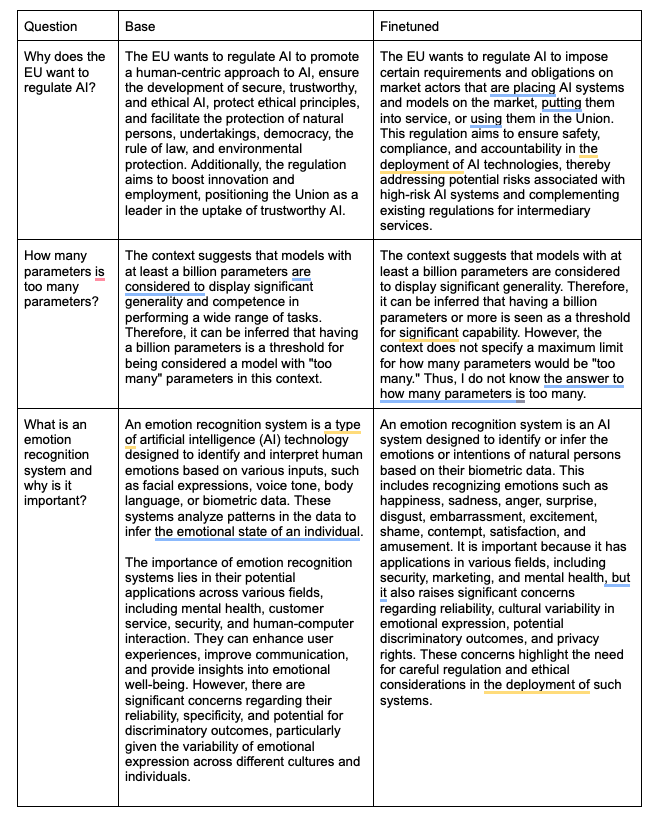

#### 🟢 Answer #2:

Based on the key questions compared, the finetuned RAG answered the questions better, specifically in the question of "How many parameters is too many parameters?" where it admitted its knowledge limitations compared to the potentially misleading answer of the base RAG.

As a former writer, I also prefer finetuned RAG's active and forcible style of answering compared to the based RAG's passive and meandering style. However, it should be noted that the finetuned answer generated more phrasing issues.

## Task 2: RAGAS Evaluation

It's great to have some idea of how our system is doing based on vibe-checks, but let's use RAGAS to provide more insight info. on how things are improving!

In [ ]:
!pip install -qU ragas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 185.7/185.7 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.1/71.1 kB 6.4 MB/s eta 0:00:00


### RAGAS Synthetic Testset Generation

First things first, we need to generate some data to test our model on.

Let's use our test data that we created before as a base!

In [ ]:
from langchain_core.pydantic_v1 import BaseModel


In [ ]:
from ragas.testset.generator import TestsetGenerator
from ragas.testset.evolutions import simple, reasoning, multi_context
from langchain_openai import OpenAIEmbeddings

generator_llm = ChatOpenAI(model="gpt-3.5-turbo")
critic_llm = ChatOpenAI(model="gpt-4o-mini")
embeddings = OpenAIEmbeddings()

In [ ]:
generator = TestsetGenerator.from_langchain(
    generator_llm,
    critic_llm,
    embeddings
)

In [ ]:
testset = generator.generate_with_langchain_docs(
    test_split_documents,
    test_size=20,
    distributions={simple: 0.5, reasoning: 0.25, multi_context: 0.25},
    raise_exceptions=False
    )

embedding nodes:   0%|          | 0/100 [00:00<?, ?it/s]

Generating:   0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
for doc in test_split_documents:
    print(doc.page_content, doc.metadata)


(154) The national competent authorities should exercise their powers independently, impartially and without bias, so as to safeguard the principles of objectivity of their activities and tasks and to ensure the application and implementation of this Regulation. The members of these authorities should refrain from any action incompatible with their duties and should be subject to confidentiality rules under this Regulation. {'source': 'eu_ai_act.html', 'id': '39eb215c-2862-40f4-884e-5175d0462e3d'}
(155) In order to ensure that providers of high-risk AI systems can take into account the experience on the use of high-risk AI systems for improving their systems and the design and development process or can take any possible corrective action in a timely manner, all providers should have a post-market monitoring system in place. Where relevant, post-market monitoring should include an analysis of the interaction with other AI systems including other devices and software. Post-market monito

In [ ]:
testset.to_pandas().head()

question  \
0  How does the right to obtain an explanation ap...   
1  What is the objective of promoting the uptake ...   
2  What is the role of the European Parliament in...   
3  How can the development of AI systems other th...   
4  What is included in the scope of Union financi...   

                                            contexts  \
0  [(171) Affected persons should have the right ...   
1  [(176) Since the objective of this Regulation,...   
2  [(174) Given the rapid technological developme...   
3  [(165) The development of AI systems other tha...   
4  [undertakings and insurance holding companies ...   

                                        ground_truth evolution_type  \
0  The right to obtain an explanation applies to ...         simple   
1  The objective of promoting the uptake of human...         simple   
2  The Commission should evaluate and review this...         simple   
3  The development of AI systems other than high-...         simple   
4  Undertakings and insurance holding companies u...         simple   

                                            metadata  episode_done  
0  [{'source': 'eu_ai_act.html', 'id': '610502a8-...          True  
1  [{'source': 'eu_ai_act.html', 'id': 'ab0da426-...          True  
2  [{'source': 'eu_ai_act.html', 'id': '25c8c027-...          True  
3  [{'source': 'eu_ai_act.html', 'id': 'bad7a72a-...          True  
4  [{'source': 'eu_ai_act.html', 'id': '9c66e276-...          True

### Generating Answer Datasets

For each of our pipelines, let's generate answers to these questions!

Once we have our: Questions, Answers, Contexts, Ground Truths we can move on to evaluating our datasets!

In [ ]:
from datasets import Dataset

def generate_answers(chain, testset):
  answers = []
  contexts = []
  questions = testset.to_pandas()["question"].values.tolist()
  ground_truths = testset.to_pandas()["ground_truth"].values.tolist()

  for question in tqdm.tqdm(questions):
    answer = chain.invoke({"question" : question})
    answers.append(answer["response"])
    contexts.append([context.page_content for context in answer["context"]])

  return Dataset.from_dict({
      "question" : questions,
      "answer" : answers,
      "contexts" : contexts,
      "ground_truth" : ground_truths
  })

In [ ]:
base_dataset = generate_answers(base_rag_chain, testset)

100%|██████████| 17/17 [00:16<00:00,  1.06it/s]


In [ ]:
finetune_dataset = generate_answers(finetune_rag_chain, testset)

100%|██████████| 17/17 [00:22<00:00,  1.31s/it]


### Evaluating Using the Test Set

Now that we have a test set - it's time to evaluate our pipelines with it!

In [ ]:
from ragas.metrics import (
    context_recall,
    context_precision,
)

In [ ]:
from ragas import evaluate

result = evaluate(
    base_dataset,
    metrics=[
        context_precision,
        context_recall,
    ],
)

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
result

{'context_precision': 0.6154, 'context_recall': 0.5686}

In [ ]:
result.to_pandas().head()

question  \
0  What role do downstream providers play in lodg...   
1  How should key performance indicators be used ...   
2  How does the scientific panel support the moni...   
3  How does the right to obtain an explanation ap...   
4  What specific safeguard procedure should be se...   

                                            contexts  \
0  [the results of its monitoring activities, or ...   
1  [evaluate the performance and behaviour of per...   
2  [addition to the monitoring activities of the ...   
3  [right to obtain an explanation should not app...   
4  [of protection or the need for compliance with...   

                                              answer  \
0  Downstream providers have the role of lodging ...   
1  The provided context does not contain specific...   
2  The scientific panel supports the monitoring a...   
3  The right to obtain an explanation does not ap...   
4                                     I do not know.   

                                        ground_truth  context_precision  \
0  Downstream providers play a role in lodging co...           1.000000   
1  Key performance indicators should be used to m...           0.250000   
2  The scientific panel supports the monitoring a...           0.250000   
3  The right to obtain an explanation applies to ...           0.854167   
4  A specific safeguard procedure should be set f...           0.250000   

   context_recall  
0             0.5  
1             0.0  
2             1.0  
3             0.5  
4             1.0

In [ ]:
result = evaluate(
    finetune_dataset,
    metrics=[
        context_precision,
        context_recall,
    ],
)

Evaluating:   0%|          | 0/34 [00:00<?, ?it/s]

In [ ]:
result

{'context_precision': 0.7702, 'context_recall': 0.8186}

In [ ]:
result.to_pandas().head()

question  \
0  What role do downstream providers play in lodg...   
1  How should key performance indicators be used ...   
2  How does the scientific panel support the moni...   
3  How does the right to obtain an explanation ap...   
4  What specific safeguard procedure should be se...   

                                            contexts  \
0  [2. Downstream providers shall have the right ...   
1  [as a basis for the drafting of codes of condu...   
2  [(163) With a view to complementing the govern...   
3  [(171) Affected persons should have the right ...   
4  [(e) the extent to which the use of an AI syst...   

                                              answer  \
0  Downstream providers have the right to lodge c...   
1  Key performance indicators (KPIs) should be us...   
2  The scientific panel supports the monitoring a...   
3  The right to obtain an explanation applies to ...   
4  The context provided does not specify a partic...   

                                        ground_truth  context_precision  \
0  Downstream providers play a role in lodging co...           1.000000   
1  Key performance indicators should be used to m...           0.416667   
2  The scientific panel supports the monitoring a...           0.966667   
3  The right to obtain an explanation applies to ...           1.000000   
4  A specific safeguard procedure should be set f...           0.810000   

   context_recall  
0        0.500000  
1        0.333333  
2        1.000000  
3        1.000000  
4        1.000000

#### 🏗️ Activity #3:

Discuss changes that you'd make to this pipeline based on the performance improvements that you see with RAGAS and the fine-tuning.

Come up with 3 changes, and then we'll discuss these options as a group!

1. Considering that overfitting is on purpose, use other loss functions like triplet loss and contrastive loss to further minimize distance between related questions and documents and maximizing distance between unrelated ones.
2. We can consider if overall precision and recall metrics would improve if we change the question evolution distributions as the finetuned model might be better at reasoning and multi-context questions.
3. Changing generator and critic llms might improve the overall quality of the questions and quality of the answers leading to better performance.
